In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/medical-insurance-cost-dataset/insurance.csv


In [2]:
import pandas as pd
df = pd.read_csv('/kaggle/input/medical-insurance-cost-dataset/insurance.csv')
df1 = df.copy()
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:

import os
import random
import numpy as np

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Import common libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, accuracy_score

# Define evaluation metrics dictionary (customize based on problem type)
EVAL_METRICS = {
    'regression': ['MAE', 'MSE', 'RMSE', 'R2'],
    'classification': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'time_series': ['MAPE', 'RMSE'],
    'clustering': ['Silhouette Score', 'Davies-Bouldin Index']
}

# Create project directories if not existing
PROJECT_DIRS = ['data', 'notebooks', 'scripts', 'models', 'reports']
for d in PROJECT_DIRS:
    if not os.path.exists(d):
        os.makedirs(d)

print(f"Project directories created: {PROJECT_DIRS}")
print(f"Random seed set to: {RANDOM_SEED}")

# Example function to print problem details (based on prior knowledge)
def print_problem_summary(problem_type):
    metrics = EVAL_METRICS.get(problem_type.lower())
    print(f"Problem Type: {problem_type}")
    print(f"Suggested Evaluation Metrics: {metrics}")

# Example usage (replace 'regression' with your known problem type)
print_problem_summary('regression')


Project directories created: ['data', 'notebooks', 'scripts', 'models', 'reports']
Random seed set to: 42
Problem Type: regression
Suggested Evaluation Metrics: ['MAE', 'MSE', 'RMSE', 'R2']


In [4]:
!pip install ydata-profiling
!pip install pydantic-settings
from pydantic_settings import BaseSettings
from ydata_profiling import ProfileReport
!pip install ipywidgets

def profile_data(df: pd.DataFrame, output_file: str = None):
    """
    Generate an interactive data profiling report.
    """
    profile = ProfileReport(df, title="Dataset Profiling Report", explorative=True)
    if output_file:
        profile.to_file(output_file)
    else:
        profile.to_notebook_iframe()
    return profile

def auto_detect_problem_type(df: pd.DataFrame, target_col: str = None) -> str:
    """
    Automatically detect the ML problem type based on target column and dataset.
    """
    if target_col is None or target_col not in df.columns:
        return "unsupervised (clustering or other)"

    target = df[target_col]
    datetime_cols = df.select_dtypes(include=['datetime64[ns]', 'datetime64']).columns
    if pd.api.types.is_datetime64_any_dtype(df.index) or len(datetime_cols) > 0:
        if pd.api.types.is_numeric_dtype(target):
            return "time series regression"
        else:
            return "time series classification"

    if pd.api.types.is_numeric_dtype(target):
        unique_vals = target.nunique()
        if unique_vals > 20:
            return "regression"
        else:
            return "classification"

    if pd.api.types.is_categorical_dtype(target) or target.dtype == object:
        return "classification"

    return "unknown"

# Example usage
# DATA_PATH = "/kaggle/input/airlines-flights-data/airlines_flights_data.csv"
TARGET_COL = "charges"  # Replace with actual target column name

# df = pd.read_csv(DATA_PATH)

# Profile dataset (generates interactive report in notebook or saves to file)
profile = profile_data(df)  # For Jupyter notebook display
# profile = profile_data(df, output_file="data_profile_report.html")  # To save HTML report

# Auto detect problem type
problem_type = auto_detect_problem_type(df, TARGET_COL)
print(f"Auto-detected problem type: {problem_type}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.0 MB/s eta 0:00:00


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 7/7 [00:00<00:00, 163.33it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Auto-detected problem type: regression


In [5]:
num_cols = df1.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df1.select_dtypes(include=['object', 'category']).columns

def remove_duplicates(df):
    """
    Remove duplicate rows from dataset.
    """
    before = len(df)
    df = df.drop_duplicates()
    after = len(df)
    print(f"Duplicates removed: {before - after}")
    print("remove dups completed")
    return df
remove_duplicates(df)


def check_missing_values(df):
    """
    Display missing value counts and percentages per column.
    """
    missing = df.isnull().sum()
    percent = (missing / len(df)) * 100
    missing_df = pd.DataFrame({'MissingCount': missing, 'MissingPercent': percent})
    print(missing_df[missing_df['MissingCount'] > 0])
check_missing_values(df)

# Imputation example: mean for numerical, mode for categorical
def impute_missing_values(df, num_cols, cat_cols):
    """
    Impute missing values in numerical and categorical columns.
    """
    for col in num_cols:
        mean_value = df[col].mean()
        df[col].fillna(mean_value, inplace=True)

    for col in cat_cols:
        mode_value = df[col].mode()[0]
        df[col].fillna(mode_value, inplace=True)
    return df
impute_missing_values(df, num_cols,cat_cols )

Duplicates removed: 1
remove dups completed
Empty DataFrame
Columns: [MissingCount, MissingPercent]
Index: []


/tmp/ipykernel_13/4022495674.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mean_value, inplace=True)
/tmp/ipykernel_13/4022495674.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


--- Skewness of Numerical Features ---
          Skewness
charges   1.515880
children  0.938380
bmi       0.284047
age       0.055673


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


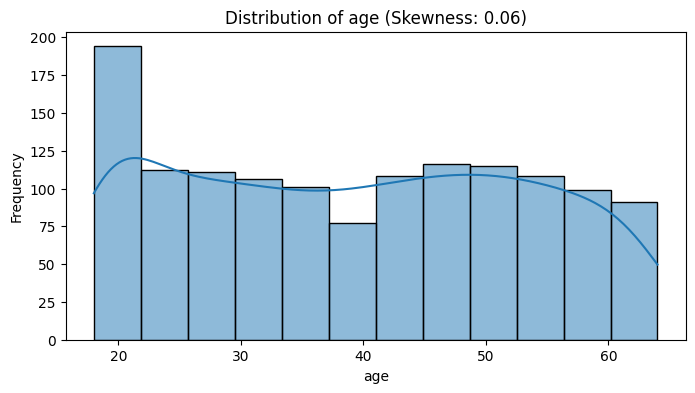

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


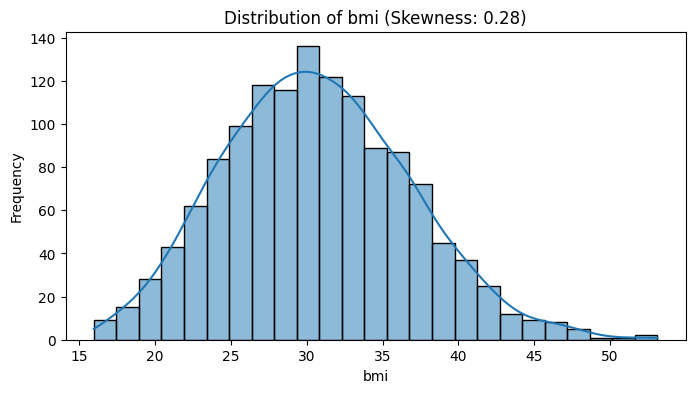

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


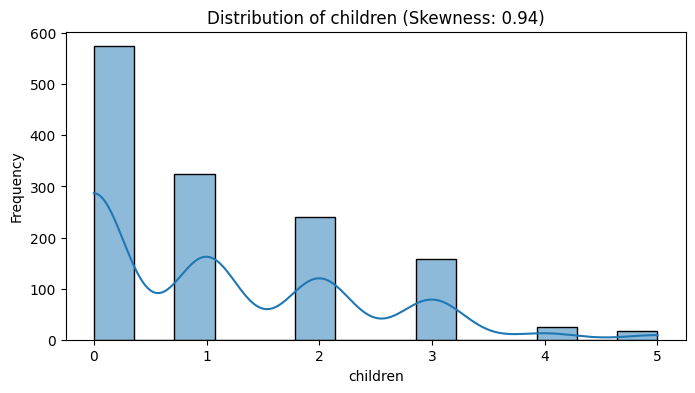

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


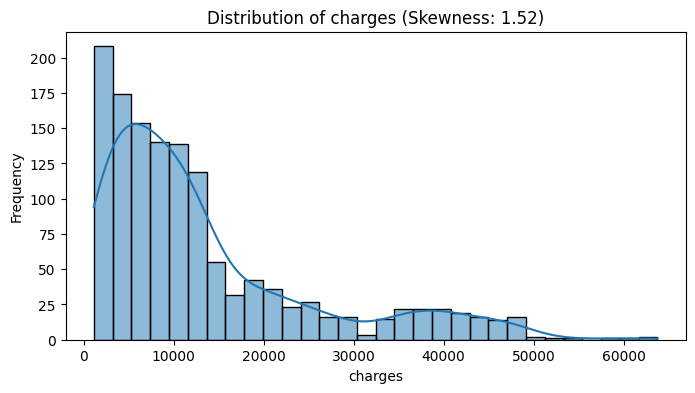

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def check_skewness(df: pd.DataFrame):
    """
    Calculates and prints the skewness for all numerical columns,
    and visualizes the distributions with histograms.
    """
    # Automatically select only numerical columns
    num_cols = df.select_dtypes(include=np.number).columns.tolist()
    
    print("--- Skewness of Numerical Features ---")
    
    # Corrected and simplified approach
    skewness_series = df[num_cols].skew().sort_values(ascending=False)
    skewness_df = skewness_series.to_frame(name='Skewness')
    
    print(skewness_df)
    
    # Optional: Plot histograms to visualize the distributions
    for col in num_cols:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col} (Skewness: {df[col].skew():.2f})')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

# Example usage (using df1 as you have instructed)
check_skewness(df1)

In [7]:
import pandas as pd
import numpy as np

def analyze_skewness(df: pd.DataFrame, skew_threshold=0.5):
    """
    Analyzes skewness of all numerical columns in a DataFrame and suggests actions.

    Parameters:
    - df: The input pandas DataFrame.
    - skew_threshold: The threshold to determine if a feature is skewed.
                      A common value is 0.5. Values > 0.5 are right-skewed,
                      values < -0.5 are left-skewed.
    """
    print("--- Skewness Analysis ---")
    
    # Automatically select numerical columns
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

    if not numerical_cols:
        print("No numerical columns found to analyze.")
        return

    # Calculate skewness for each numerical column
    skew_series = df[numerical_cols].skew()
    skew_df = skew_series.reset_index()
    skew_df.columns = ['Column', 'Skewness']
    
    # Classify based on the skewness threshold
    skew_df['Action'] = 'No action needed'
    skew_df.loc[skew_df['Skewness'] > skew_threshold, 'Action'] = 'Right-skewed (Positive)'
    skew_df.loc[skew_df['Skewness'] < -skew_threshold, 'Action'] = 'Left-skewed (Negative)'

    # Sort for better readability
    skew_df = skew_df.sort_values(by='Skewness', ascending=False)
    
    print(skew_df)
    
    print("\n--- Suggested Actions for Skewness ---")
    for index, row in skew_df.iterrows():
        action = row['Action']
        col = row['Column']
        if 'Right-skewed' in action:
            print(f"- **{col}**: The distribution has a long tail to the right. Consider a **log transformation** (np.log or np.log1p) or a **square root transformation** to normalize it.")
        elif 'Left-skewed' in action:
            print(f"- **{col}**: The distribution has a long tail to the left. Consider **squaring or cubing the variable** to normalize it.")
        else:
            print(f"- **{col}**: The distribution is approximately symmetric. No transformation is typically required.")
            
# Using your copy of the DataFrame, df1
analyze_skewness(df1)

--- Skewness Analysis ---
     Column  Skewness                   Action
3   charges  1.515880  Right-skewed (Positive)
2  children  0.938380  Right-skewed (Positive)
1       bmi  0.284047         No action needed
0       age  0.055673         No action needed

--- Suggested Actions for Skewness ---
- **charges**: The distribution has a long tail to the right. Consider a **log transformation** (np.log or np.log1p) or a **square root transformation** to normalize it.
- **children**: The distribution has a long tail to the right. Consider a **log transformation** (np.log or np.log1p) or a **square root transformation** to normalize it.
- **bmi**: The distribution is approximately symmetric. No transformation is typically required.
- **age**: The distribution is approximately symmetric. No transformation is typically required.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_num_vs_num(df, col1, col2):
    """
    Creates a scatter plot to visualize the relationship between two numerical columns.
    It also prints an analysis of the relationship.
    """
    print(f"--- Analyzing Numerical Relationship: '{col1}' vs. '{col2}' ---")
    
    # Check if columns are numerical
    if df[col1].dtype not in ['int64', 'float64'] or df[col2].dtype not in ['int64', 'float64']:
        print("Error: This function requires two numerical columns.")
        return

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=col1, y=col2)
    plt.title(f'Scatter Plot of {col1} vs. {col2}')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.show()

    # Calculate and print correlation
    correlation = df[col1].corr(df[col2])
    print(f"The Pearson correlation coefficient is: {correlation:.4f}")
    
    # Provide an automated analysis of the chart
    print("\n--- Plot Analysis ---")
    print("A scatter plot is used to visualize the relationship between two numerical variables.[1]")
    print("Each point on the plot represents a data observation, showing the value of both variables simultaneously.[2]")
    
    if abs(correlation) > 0.7:
        print(f"The plot reveals a strong linear relationship. As the value of '{col1}' increases, the value of '{col2}' also tends to {'increase' if correlation > 0 else 'decrease'}.[1]")
    elif abs(correlation) > 0.3:
        print(f"The plot suggests a moderate linear relationship. There is a general trend, but the data points are not tightly clustered around a single line.[1]")
    else:
        print(f"The plot shows a weak or no linear relationship. The data points appear scattered, with no clear trend.[1]")

    # Check for outliers
    outliers_x = df[(np.abs(df[col1] - df[col1].mean()) > 3 * df[col1].std())]
    outliers_y = df[(np.abs(df[col2] - df[col2].mean()) > 3 * df[col2].std())]
    
    if not outliers_x.empty or not outliers_y.empty:
        print("The chart may also contain outliers, which are data points that are far away from the rest of the data.[2]")
    
    print("-" * 40)


def plot_cat_vs_cat(df, col1, col2):
    """
    Creates a grouped bar chart to visualize the relationship between two categorical columns.
    It also prints an analysis of the relationship.
    """
    print(f"--- Analyzing Categorical Relationship: '{col1}' vs. '{col2}' ---")

    # Check if columns are categorical
    if df[col1].dtype not in ['object', 'category'] or df[col2].dtype not in ['object', 'category']:
        print("Error: This function requires two categorical columns.")
        return

    plt.figure(figsize=(12, 8))
    sns.countplot(x=col1, hue=col2, data=df)
    plt.title(f'Grouped Bar Chart of {col1} vs. {col2}')
    plt.xlabel(col1)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title=col2)
    plt.tight_layout()
    plt.show()

    # Provide an automated analysis of the chart
    print("\n--- Plot Analysis ---")
    print("This grouped bar chart is used to compare the distribution of one categorical variable across the categories of another.[3]")
    print(f"Each group of bars represents a category in '{col1}', and the individual bars within each group represent the breakdown by '{col2}'.[4]")
    print("This allows you to easily compare the counts of sub-groups side-by-side, providing insights into their relative distributions.[4]")
    print("-" * 40)


def plot_num_vs_cat(df, num_col, cat_col):
    """
    Creates a box plot to visualize the distribution of a numerical column across categories.
    It also prints an analysis of the distribution.
    """
    print(f"--- Analyzing Relationship: '{num_col}' vs. '{cat_col}' ---")

    # Check column types
    if df[num_col].dtype not in ['int64', 'float64'] or df[cat_col].dtype not in ['object', 'category']:
        print("Error: This function requires one numerical and one categorical column.")
        return

    plt.figure(figsize=(10, 6))
    sns.boxplot(x=cat_col, y=num_col, data=df)
    plt.title(f'Box Plot of {num_col} by {cat_col}')
    plt.xlabel(cat_col)
    plt.ylabel(num_col)
    plt.show()

    # Provide an automated analysis of the chart
    print("\n--- Plot Analysis ---")
    print("A box plot is used to compare the distribution of a numerical variable across different categories.[3, 2]")
    print("Each box represents a category and shows key statistical measures: the median (line in the box), the interquartile range (the box itself), and potential outliers (points outside the whiskers).[3]")
    print(f"The plot allows you to quickly compare the central tendency, spread, and outliers of '{num_col}' for each group in '{cat_col}'.[3, 2]")
    print("-" * 40)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


                age   sex          bmi     children smoker     region  \
count   1338.000000  1338  1338.000000  1338.000000   1338       1338   
unique          NaN     2          NaN          NaN      2          4   
top             NaN  male          NaN          NaN     no  southeast   
freq            NaN   676          NaN          NaN   1064        364   
mean      39.207025   NaN    30.663397     1.094918    NaN        NaN   
std       14.049960   NaN     6.098187     1.205493    NaN        NaN   
min       18.000000   NaN    15.960000     0.000000    NaN        NaN   
25%       27.000000   NaN    26.296250     0.000000    NaN        NaN   
50%       39.000000   NaN    30.400000     1.000000    NaN        NaN   
75%       51.000000   NaN    34.693750     2.000000    NaN        NaN   
max       64.000000   NaN    53.130000     5.000000    NaN        NaN   

             charges  
count    1338.000000  
unique           NaN  
top              NaN  
freq             NaN  
mean    

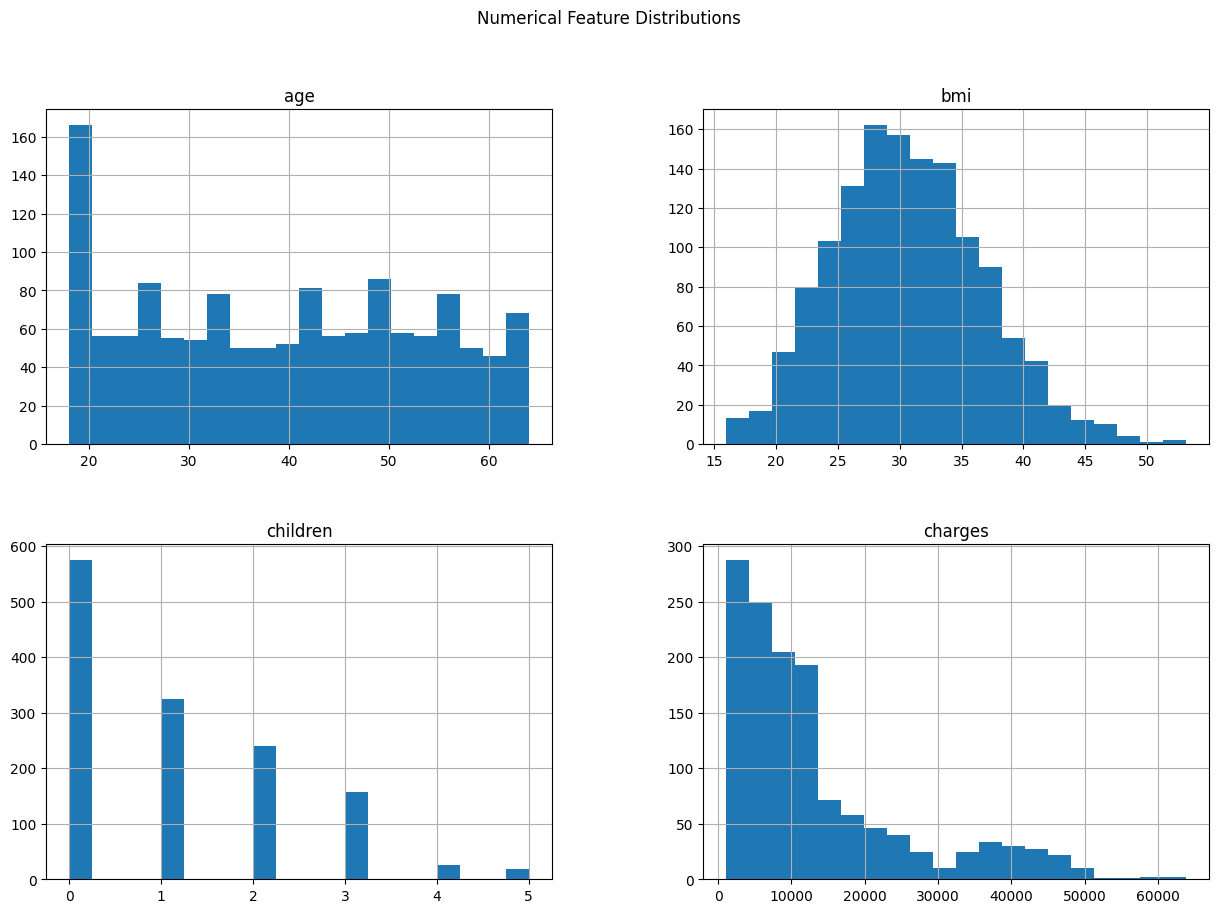

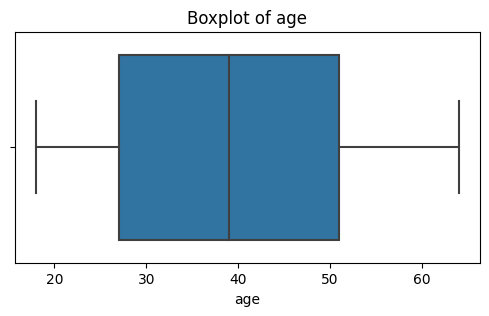

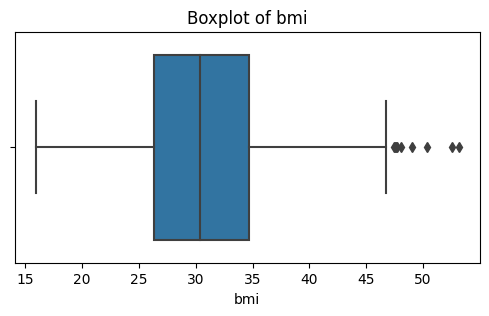

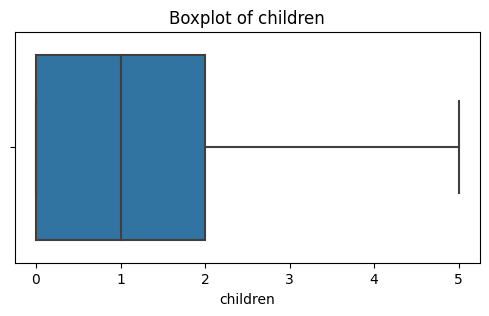

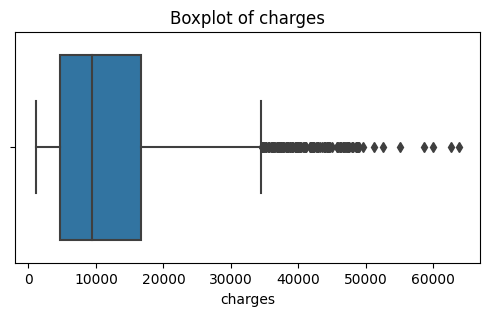

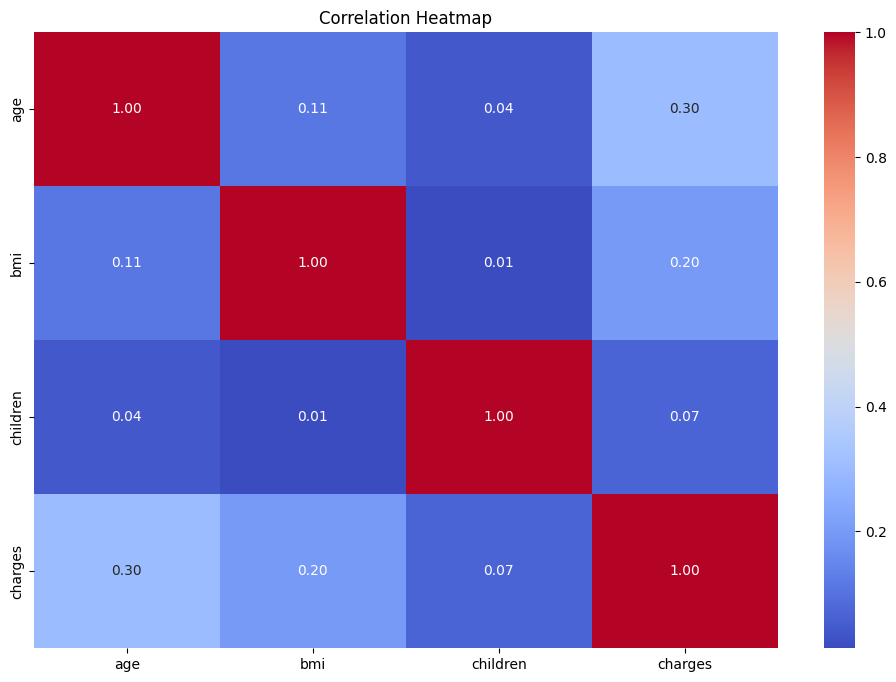

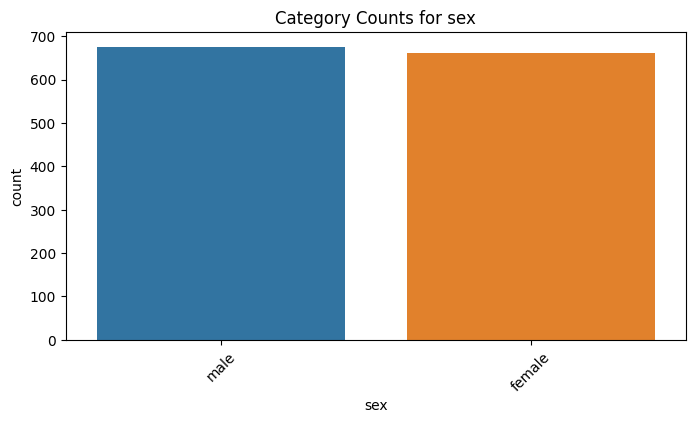

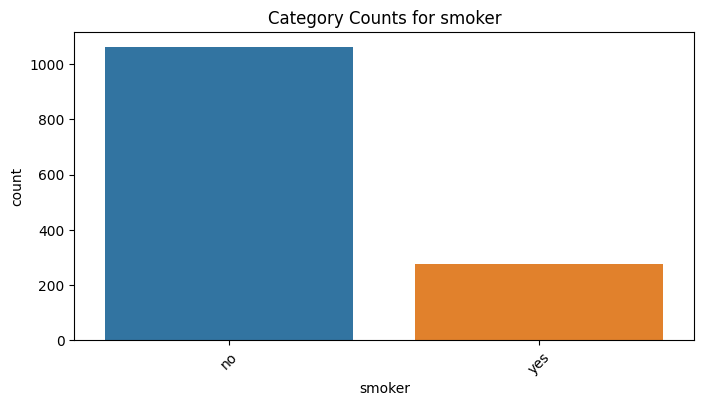

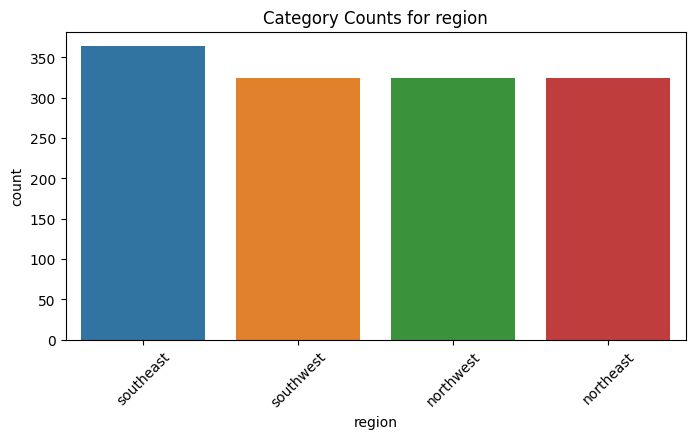

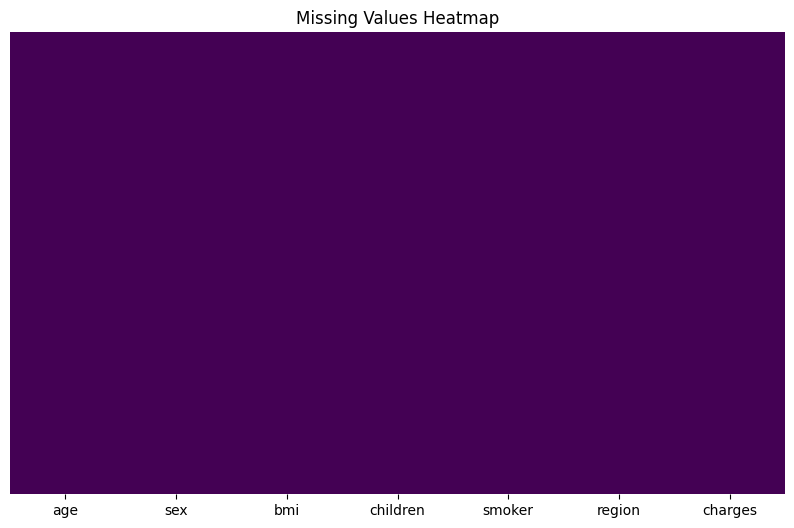

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# # Load dataset (replace with actual path)
# DATA_PATH = "data/dataset.csv"
# df = pd.read_csv(DATA_PATH)

# df = df.drop(columns = {"df_index"})

# Basic statistical summary
print(df.describe(include='all'))

# Separate numerical and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns

# Histograms for numerical features
df[num_cols].hist(bins=20, figsize=(15, 10))
plt.suptitle("Numerical Feature Distributions")
plt.show()

# Boxplots for outlier visualization
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

# Correlation heatmap (Pearson)
plt.figure(figsize=(12, 8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Countplots for categorical features
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Category Counts for {col}")
    plt.xticks(rotation=45)
    plt.show()

# Missing values heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()


--- Checking Normality for 'age' ---
P-value: 0.0000
Conclusion: 'age' is likely NOT normal.

--- Checking Normality for 'bmi' ---
P-value: 0.0000
Conclusion: 'bmi' is likely NOT normal.

--- Checking Normality for 'children' ---
P-value: 0.0000
Conclusion: 'children' is likely NOT normal.

--- Checking Normality for 'charges' ---
P-value: 0.0000
Conclusion: 'charges' is likely NOT normal.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

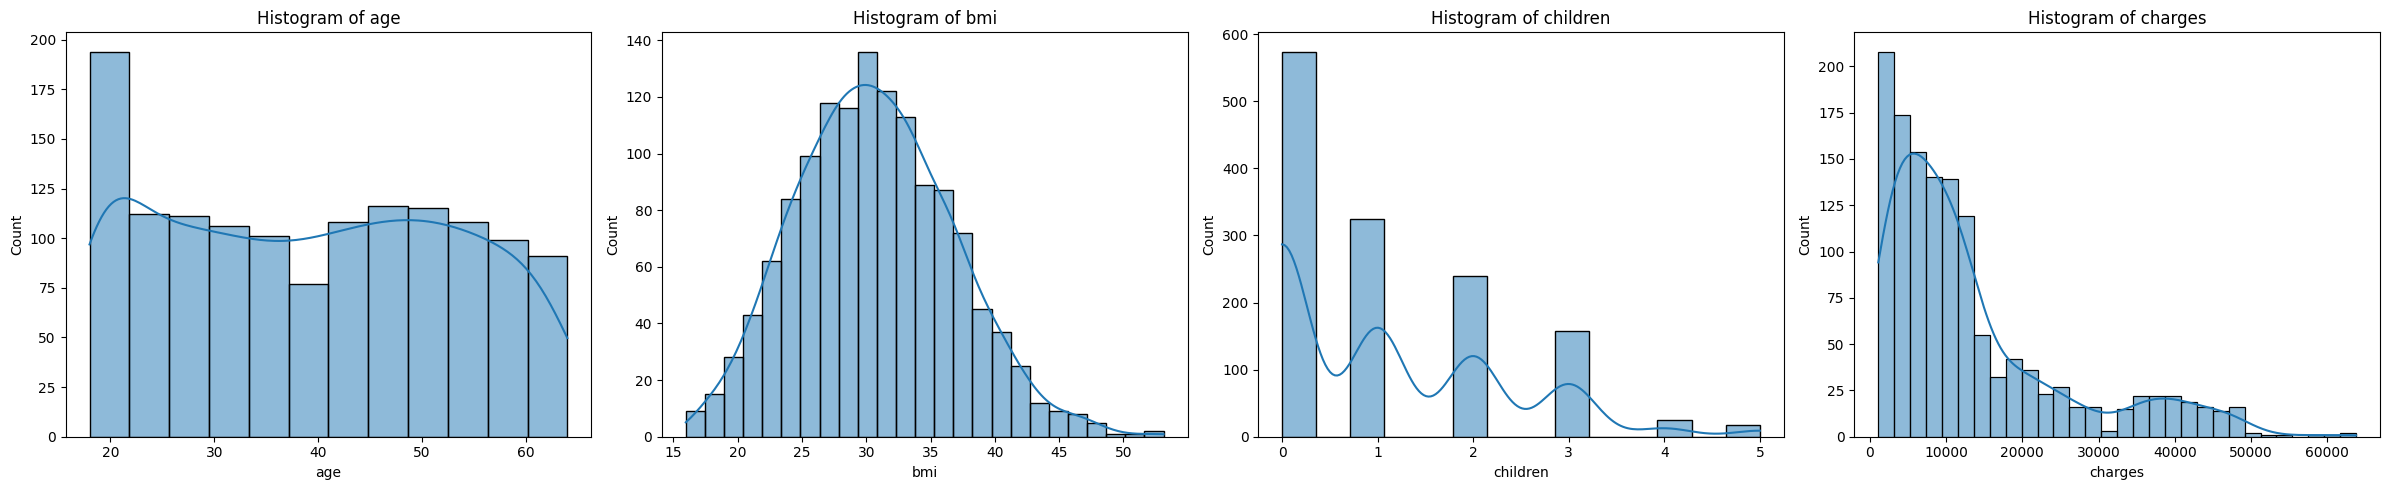

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

# Assuming 'df1' is your DataFrame, already loaded.

# Get a list of all numerical columns
numerical_cols = df1.select_dtypes(include=np.number).columns.tolist()

# Loop through each numerical column
for col in numerical_cols:
    print(f"\n--- Checking Normality for '{col}' ---")
    data_to_test = df1[col].dropna()
    
    # Check if there's enough data for the test
    if len(data_to_test) < 3:
        print("Not enough data to perform Shapiro-Wilk test.")
        continue
    
    # Perform the Shapiro-Wilk test
    stat, p_value = shapiro(data_to_test)
    
    print(f"P-value: {p_value:.4f}")
    
    # Interpret the result
    if p_value > 0.05:
        print(f"Conclusion: '{col}' is likely normal.")
    else:
        print(f"Conclusion: '{col}' is likely NOT normal.")

# This part is for plotting and is optional for the normality check itself
if numerical_cols:
    num_plots = len(numerical_cols)
    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5))
    if num_plots == 1:
        axes = [axes]
    
    for i, col in enumerate(numerical_cols):
        sns.histplot(df1[col].dropna(), kde=True, ax=axes[i])
        axes[i].set_title(f'Histogram of {col}')
        
    plt.tight_layout()
    plt.show()

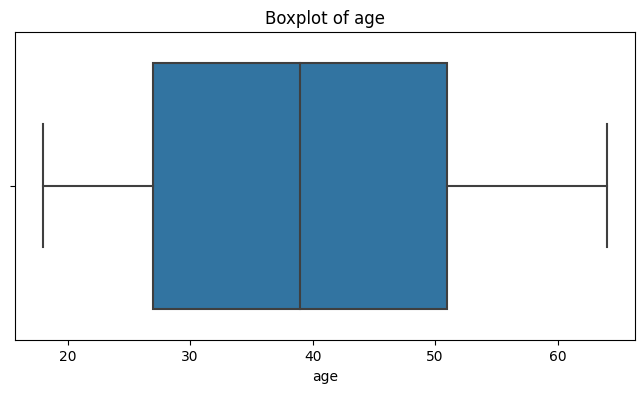

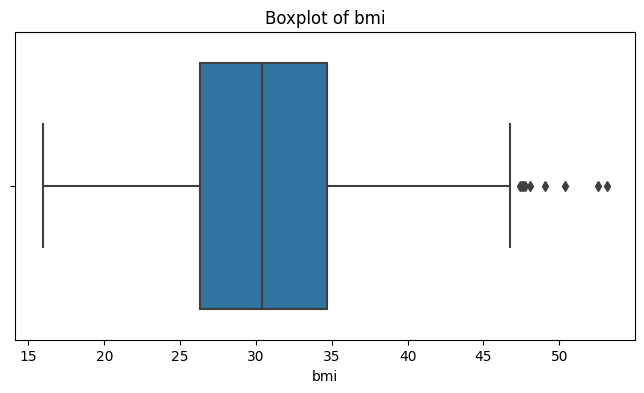

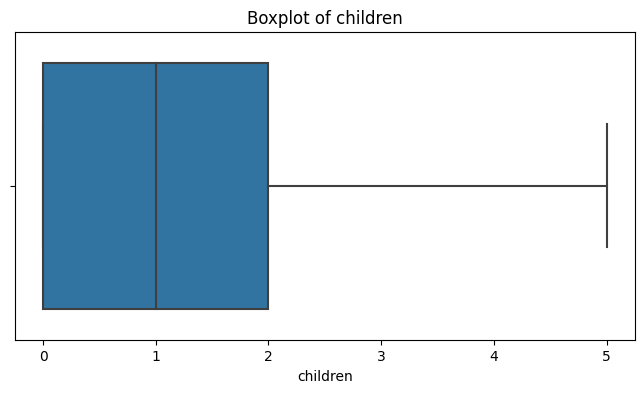

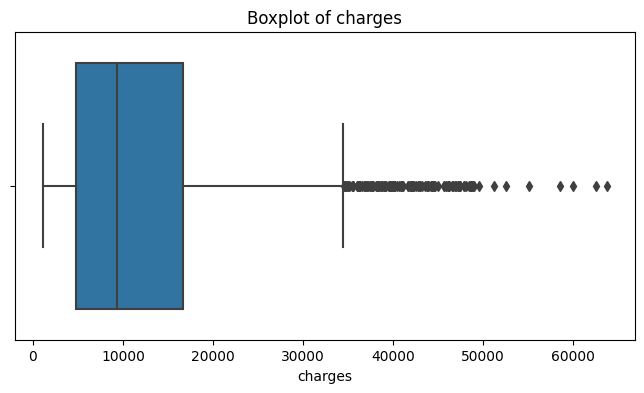

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_boxplots(data):
    """
    Plot boxplots for all numeric columns in a DataFrame.
    """
    # Find all numeric columns in the DataFrame
    numeric_cols = data.select_dtypes(include=np.number).columns.tolist()

    # Check if any numeric columns were found
    if not numeric_cols:
        print("No numeric columns found to plot.")
        return

    # Loop through the list of numeric column names
    for col in numeric_cols:
        plt.figure(figsize=(8, 4)) # Adjusted figure size for better readability
        sns.boxplot(x=data[col])
        plt.title(f"Boxplot of {col}")
        plt.show()

plot_boxplots(df)

In [12]:
#After Cleaning as well if any outliers use winsorize to cap. outliers correction only applicatble for num cols. 
#if col hav outlier is normal then apply zscore technique
#when not col data is not normal or skew then use below normal to find the outliers


def detect_outliers_iqr(data, col):
    """
    Detect outliers in a column using the IQR method.
    """
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    return outliers

outliers_in_duration = detect_outliers_iqr(df, 'charges')
outliers_in_price = detect_outliers_iqr(df, 'bmi')

# Now you can print or view the results.
print("Outliers in the 'charges' column:")
print(outliers_in_duration)

print("\nOutliers in the 'bmi' column:")
print(outliers_in_price)


Outliers in the 'charges' column:
      age     sex     bmi  children smoker     region      charges
14     27    male  42.130         0    yes  southeast  39611.75770
19     30    male  35.300         0    yes  southwest  36837.46700
23     34  female  31.920         1    yes  northeast  37701.87680
29     31    male  36.300         2    yes  southwest  38711.00000
30     22    male  35.600         0    yes  southwest  35585.57600
...   ...     ...     ...       ...    ...        ...          ...
1300   45    male  30.360         0    yes  southeast  62592.87309
1301   62    male  30.875         3    yes  northwest  46718.16325
1303   43    male  27.800         0    yes  southwest  37829.72420
1313   19  female  34.700         2    yes  southwest  36397.57600
1323   42  female  40.370         2    yes  southeast  43896.37630

[139 rows x 7 columns]

Outliers in the 'bmi' column:
      age     sex    bmi  children smoker     region      charges
116    58    male  49.06         0     no

In [13]:
import pandas as pd
import numpy as np

# Assuming 'df' is your DataFrame
# List of columns to apply winsorization on
# It is best to apply this only on columns you know have outliers
cols_to_winsorize = ['charges', 'bmi'] 

def winsorize_column(data, col):
    """
    Caps outliers using the IQR method bounds.
    """
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Use np.clip for a more concise way to cap the values
    data[col] = np.clip(data[col], lower_bound, upper_bound)
    
    return data

# Loop through the list of columns and apply the function
for col in cols_to_winsorize:
    df = winsorize_column(df, col)
    print(f"Winsorized outliers in column: {col}")

Winsorized outliers in column: charges
Winsorized outliers in column: bmi


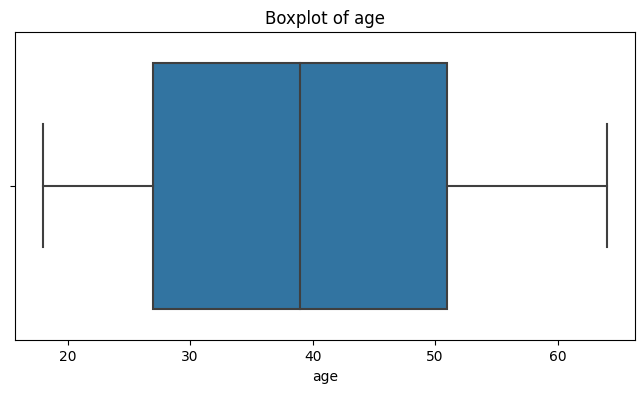

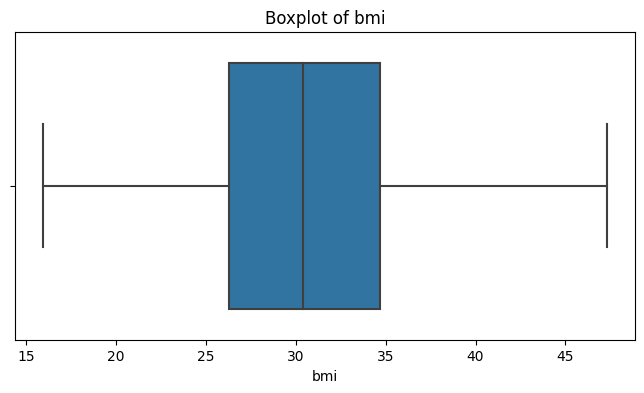

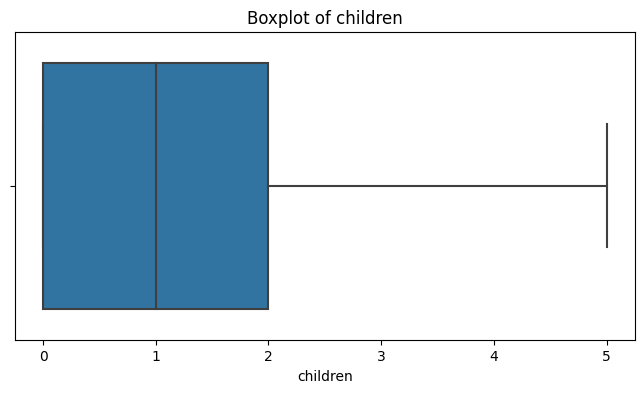

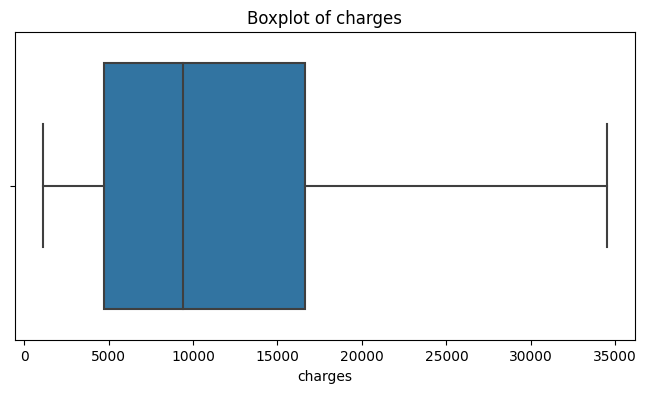

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_boxplots(data):
    """
    Plot boxplots for all numeric columns in a DataFrame.
    """
    # Find all numeric columns in the DataFrame
    numeric_cols = data.select_dtypes(include=np.number).columns.tolist()

    # Check if any numeric columns were found
    if not numeric_cols:
        print("No numeric columns found to plot.")
        return

    # Loop through the list of numeric column names
    for col in numeric_cols:
        plt.figure(figsize=(8, 4)) # Adjusted figure size for better readability
        sns.boxplot(x=data[col])
        plt.title(f"Boxplot of {col}")
        plt.show()

plot_boxplots(df)

In [15]:
df.shape

(1338, 7)

In [16]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def heuristic_auto_encode(df, ordinal_threshold=5):
    """
    Automatically applies Label Encoding or One-Hot Encoding based on a
    cardinality threshold.
    
    Args:
        df (pd.DataFrame): The DataFrame to encode.
        ordinal_threshold (int): The maximum number of unique categories
                                 for a column to be considered for Label Encoding.
        
    Returns:
        pd.DataFrame: A new DataFrame with all categorical columns encoded.
    """
    encoded_df = df.copy()
    
    all_cat_cols = encoded_df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    label_encode_cols = []
    ohe_cols = []
    
    for col in all_cat_cols:
        if encoded_df[col].nunique() <= ordinal_threshold:
            # Assume columns with few unique values are ordinal
            label_encode_cols.append(col)
        else:
            # Assume columns with many unique values are nominal
            ohe_cols.append(col)
            
    # Apply Label Encoding
    for col in label_encode_cols:
        le = LabelEncoder()
        encoded_df[col] = le.fit_transform(encoded_df[col])
        print(f"Applied Label Encoding to: {col} (Unique values: {df[col].nunique()})")
    
    # Apply One-Hot Encoding
    encoded_df = pd.get_dummies(encoded_df, columns=ohe_cols, drop_first=True)
    print(f"Applied One-Hot Encoding to: {ohe_cols}")
        
    return encoded_df

# --- How to use this function ---
# Assuming df1 is your cleaned DataFrame
df_encoded = heuristic_auto_encode(df1, ordinal_threshold=5)

print("\nFirst 5 rows of the encoded DataFrame:")
print(df_encoded.head())


Applied Label Encoding to: sex (Unique values: 2)
Applied Label Encoding to: smoker (Unique values: 2)
Applied Label Encoding to: region (Unique values: 4)
Applied One-Hot Encoding to: []

First 5 rows of the encoded DataFrame:
   age  sex     bmi  children  smoker  region      charges
0   19    0  27.900         0       1       3  16884.92400
1   18    1  33.770         1       0       2   1725.55230
2   28    1  33.000         3       0       2   4449.46200
3   33    1  22.705         0       0       1  21984.47061
4   32    1  28.880         0       0       1   3866.85520


In [17]:
total_rows = len(df)

# Check all columns and identify those with high cardinality
cols_to_exclude = []
for col in df1.columns:
    unique_ratio = df[col].nunique() / total_rows
    if unique_ratio > 0.95:  # You can adjust this threshold
        cols_to_exclude.append(col)
        print(f"Column '{col}' has a unique ratio of {unique_ratio:.2f} and should likely be excluded.")

print(f"\nFinal list of columns to exclude: {cols_to_exclude}")


Final list of columns to exclude: []


In [18]:
# Assuming 'df' is your DataFrame
categorical_summary = df.select_dtypes(include=['object', 'category']).describe().T

print(categorical_summary)

       count unique        top  freq
sex     1338      2       male   676
smoker  1338      2         no  1064
region  1338      4  southeast   364


In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

def magic_auto_encode(df, low_cardinality_threshold=5, high_cardinality_threshold=50):
    """
    Automatically applies different encoders based on the number of unique values.

    Args:
        df (pd.DataFrame): The DataFrame to encode.
        low_cardinality_threshold (int): Max unique values for Label Encoding.
        high_cardinality_threshold (int): Min unique values for Binary Encoding.

    Returns:
        pd.DataFrame: A new DataFrame with all categorical columns encoded.
    """
    encoded_df = df.copy()
    
    # Identify all categorical columns
    all_cat_cols = encoded_df.select_dtypes(include=['object', 'category']).columns.tolist()
    label_encode_cols = []
    ohe_cols = []
    binary_encode_cols = []
    
    for col in all_cat_cols:
        n_unique = encoded_df[col].nunique()
        if n_unique <= low_cardinality_threshold:
            label_encode_cols.append(col)
        elif n_unique > high_cardinality_threshold:
            binary_encode_cols.append(col)
        else:
            ohe_cols.append(col)
    
    print("--- Encoding Summary ---")
    print(f"Applying Label Encoding to: {label_encode_cols}")
    print(f"Applying One-Hot Encoding to: {ohe_cols}")
    print(f"Applying Binary Encoding to: {binary_encode_cols}")
    
    # Apply Label Encoding
    for col in label_encode_cols:
        le = LabelEncoder()
        encoded_df[col] = le.fit_transform(encoded_df[col])
    
    # Apply One-Hot Encoding
    encoded_df = pd.get_dummies(encoded_df, columns=ohe_cols, drop_first=True)
    
    # Apply Binary Encoding
    if binary_encode_cols:
        encoder = ce.BinaryEncoder(cols=binary_encode_cols)
        encoded_df = encoder.fit_transform(encoded_df)
        
    return encoded_df

# --- How to use this function ---
# Assuming df1 is your cleaned DataFrame
df_encoded = magic_auto_encode(df, low_cardinality_threshold=5, high_cardinality_threshold=50)

print("\nFirst 5 rows of the encoded DataFrame:")
print(df_encoded.head())

--- Encoding Summary ---
Applying Label Encoding to: ['sex', 'smoker', 'region']
Applying One-Hot Encoding to: []
Applying Binary Encoding to: []

First 5 rows of the encoded DataFrame:
   age  sex     bmi  children  smoker  region      charges
0   19    0  27.900         0       1       3  16884.92400
1   18    1  33.770         1       0       2   1725.55230
2   28    1  33.000         3       0       2   4449.46200
3   33    1  22.705         0       0       1  21984.47061
4   32    1  28.880         0       0       1   3866.85520


In [20]:
import pandas as pd
from scipy.stats import shapiro
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np

# This script is designed to work with your DataFrame, df1.
# Please ensure your df1 DataFrame is loaded and available in your environment
# before running this code.

# We will create a copy of df1 to store the scaled data
df1_scaled = df_encoded.copy()

def shapiro_test_column(data_series, column_name, alpha=0.05):
    """
    Performs the Shapiro-Wilk test for normality on a single column.
    Returns True if the data is likely normal, False otherwise.
    Includes error handling for data where the test cannot be performed.
    """
    # Shapiro-Wilk test requires at least 3 samples
    if len(data_series.dropna()) < 3:
        print(f"Skipping '{column_name}': not enough data points for the test.")
        return False
        
    try:
        # Perform the Shapiro-Wilk test
        stat, p_value = shapiro(data_series.dropna())
        
        print(f"\n--- Results for column: '{column_name}' ---")
        print(f"Shapiro-Wilk Test Statistic: {stat:.4f}")
        print(f"P-value: {p_value:.4f}")
        
        if p_value > alpha:
            print("Conclusion: The data is likely from a normal distribution.")
            return True
        else:
            print("Conclusion: The data is likely NOT from a normal distribution.")
            return False
            
    except Exception as e:
        print(f"An error occurred while testing column '{column_name}': {e}")
        return False

# Lists to store the names of columns based on their distribution
normal_columns = []
non_normal_columns = []

print("Starting normality checks on all columns in your DataFrame (df1)...\n")

# Loop through each column in the DataFrame
for column in df1.columns:
    # Check if the column is a numerical type before attempting the test
    if is_numeric_dtype(df1[column]):
        is_normal = shapiro_test_column(df1[column], column)
        
        if is_normal:
            normal_columns.append(column)
        else:
            non_normal_columns.append(column)
            
    else:
        print(f"--- Skipping non-numerical column: '{column}' ---")

print("\n" + "="*50)
print("Normality checks complete.")
print(f"Columns identified as 'normal' (p-value > 0.05): {normal_columns}")
print(f"Columns identified as 'not normal' (p-value <= 0.05): {non_normal_columns}")
print("="*50)

# Apply the appropriate scaling technique to the identified columns
if normal_columns:
    print("\nApplying StandardScaler to normal columns...")
    scaler_std = StandardScaler()
    df1_scaled[normal_columns] = scaler_std.fit_transform(df1[normal_columns])
    print("StandardScaler applied successfully.")

if non_normal_columns:
    print("\nApplying MinMaxScaler to non-normal columns...")
    scaler_minmax = MinMaxScaler()
    df1_scaled[non_normal_columns] = scaler_minmax.fit_transform(df1[non_normal_columns])
    print("MinMaxScaler applied successfully.")

print("\nFirst 5 rows of the scaled DataFrame (df1_scaled):")
print(df1_scaled.head())

Starting normality checks on all columns in your DataFrame (df1)...


--- Results for column: 'age' ---
Shapiro-Wilk Test Statistic: 0.9447
P-value: 0.0000
Conclusion: The data is likely NOT from a normal distribution.
--- Skipping non-numerical column: 'sex' ---

--- Results for column: 'bmi' ---
Shapiro-Wilk Test Statistic: 0.9939
P-value: 0.0000
Conclusion: The data is likely NOT from a normal distribution.

--- Results for column: 'children' ---
Shapiro-Wilk Test Statistic: 0.8232
P-value: 0.0000
Conclusion: The data is likely NOT from a normal distribution.
--- Skipping non-numerical column: 'smoker' ---
--- Skipping non-numerical column: 'region' ---

--- Results for column: 'charges' ---
Shapiro-Wilk Test Statistic: 0.8147
P-value: 0.0000
Conclusion: The data is likely NOT from a normal distribution.

Normality checks complete.
Columns identified as 'normal' (p-value > 0.05): []
Columns identified as 'not normal' (p-value <= 0.05): ['age', 'bmi', 'children', 'charges']

Applying

In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np

df_encoded = df.copy()

# Assuming 'df_encoded' is your DataFrame after handling outliers and encoding
# We'll create copies to keep the original data unchanged.
df_standard_scaled = df_encoded.copy()
df_minmax_scaled = df_encoded.copy()

# Identify all the numerical columns to be scaled
numerical_cols = df_encoded.select_dtypes(include=np.number).columns.tolist()

# Apply StandardScaler to one copy of the DataFrame
scaler_std = StandardScaler()
df_standard_scaled[numerical_cols] = scaler_std.fit_transform(df_standard_scaled[numerical_cols])
print("StandardScaler applied to df_standard_scaled.")
print(df_standard_scaled.head())

# Apply MinMaxScaler to another copy of the DataFrame
scaler_minmax = MinMaxScaler()
df_minmax_scaled[numerical_cols] = scaler_minmax.fit_transform(df_minmax_scaled[numerical_cols])
print("\nMinMaxScaler applied to df_minmax_scaled.")
print(df_minmax_scaled.head())

StandardScaler applied to df_standard_scaled.
        age     sex       bmi  children smoker     region   charges
0 -1.438764  female -0.454201 -0.908614    yes  southwest  0.433863
1 -1.509965    male  0.515300 -0.078767     no  southeast -1.059045
2 -0.797954    male  0.388125  1.580926     no  southeast -0.790792
3 -0.441948    male -1.312218 -0.908614     no  northwest  0.936070
4 -0.513149    male -0.292342 -0.908614     no  northwest -0.848168

MinMaxScaler applied to df_minmax_scaled.
        age     sex       bmi  children smoker     region   charges
0  0.021739  female  0.381104       0.0    yes  southwest  0.472408
1  0.000000    male  0.568465       0.2     no  southeast  0.018092
2  0.217391    male  0.543888       0.6     no  southeast  0.099725
3  0.326087    male  0.215289       0.0     no  northwest  0.625237
4  0.304348    male  0.412384       0.0     no  northwest  0.082265


In [22]:
#magic function to apply feature selction with chi, embedded(reg and classi), filter for reg and classi, 

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, chi2, f_regression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
import numpy as np

def perform_automated_feature_selection(df, target_column_name, k_features=5):
    """
    Automatically selects the most important features for a dataset.
    This function intelligently switches between methods for classification
    and regression problems.

    Args:
        df (pd.DataFrame): The DataFrame to analyze. It should already be
                           preprocessed, with numerical columns scaled and
                           categorical columns one-hot encoded.
        target_column_name (str): The name of the column you want to predict.
        k_features (int): The number of features to select using statistical tests.

    Returns:
        tuple: A new DataFrame with only the selected features, and a list of
               the names of those features.
    """
    # --- Step 1: Prepare the Data (Separate features from target) ---
    print("Step 1: Separating features (X) and target (y)...")
    X = df.drop(target_column_name, axis=1)
    y = df[target_column_name]

    # Automatically decide if it's a classification or regression problem
    # If the target has few unique values or is an object type, it's classification.
    if y.dtype == 'object' or y.dtype == 'category' or y.nunique() <= 20:
        problem_type = 'classification'
        print(f"Problem Type: Classification (Target '{target_column_name}' has {y.nunique()} unique values)")
        # Encode the target variable for classification models
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
    else:
        problem_type = 'regression'
        print(f"Problem Type: Regression (Target '{target_column_name}' is numerical)")
        y_encoded = y
    
    # Identify numerical and categorical columns from the features
    numerical_cols = X.select_dtypes(include=np.number).columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns

    # --- Step 2: Handle Categorical Features and Combine Data ---
    print("Step 2: Handling categorical features and combining data...")
    if not categorical_cols.empty:
        # One-hot encode categorical features if they exist
        X_encoded_categorical = pd.get_dummies(X[categorical_cols], drop_first=True)
        X_combined = pd.concat([X[numerical_cols], X_encoded_categorical], axis=1)
    else:
        print("No categorical columns found. Using only numerical features.")
        X_combined = X[numerical_cols]

    print(f"Features ready for selection. Total columns: {len(X_combined.columns)}")
    print("-" * 50)
    
    # --- Step 3: Choose Methods Based on Problem Type ---
    print("Step 3: Choosing feature selection methods...")
    if problem_type == 'classification':
        score_func = f_classif
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    else: # Regression
        score_func = f_regression
        model = RandomForestRegressor(n_estimators=100, random_state=42)

    # --- Step 4: Apply Filter Methods (Statistical Tests) ---
    print("Step 4: Applying statistical filter methods...")
    filtered_features = []
    
    if problem_type == 'classification' and not categorical_cols.empty:
        # Use Chi-Square for categorical features in classification
        selector_chi2 = SelectKBest(score_func=chi2, k='all')
        selector_chi2.fit(X_combined[X_encoded_categorical.columns], y_encoded)
        chi2_scores = pd.Series(selector_chi2.scores_, index=X_encoded_categorical.columns)
        
        # Use f_classif for numerical features
        selector_anova = SelectKBest(score_func=score_func, k='all')
        selector_anova.fit(X_combined[numerical_cols], y_encoded)
        anova_scores = pd.Series(selector_anova.scores_, index=numerical_cols)
        
        # Concatenate scores and get the top K features
        combined_scores = pd.concat([anova_scores, chi2_scores]).sort_values(ascending=False)
        filtered_features = combined_scores.head(k_features).index.tolist()
        print(f"Top {k_features} features from f_classif and chi-square: {filtered_features}")
        
    else: # This applies to all regression problems and classification without categorical data
        selector_filter = SelectKBest(score_func=score_func, k=k_features)
        selector_filter.fit(X_combined, y_encoded)
        filtered_scores = pd.Series(selector_filter.scores_, index=X_combined.columns)
        filtered_features = filtered_scores.nlargest(k_features).index.tolist()
        print(f"Top {k_features} features from {score_func.__name__}: {filtered_features}")

    print("-" * 50)

    # --- Step 5: Apply Embedded Method (Random Forest) ---
    print("Step 5: Applying embedded method (Random Forest)...")
    selector_embedded = SelectFromModel(model, threshold='median', prefit=False)
    selector_embedded.fit(X_combined, y_encoded)
    embedded_features = X_combined.columns[selector_embedded.get_support()].tolist()
    print(f"Features selected by Random Forest: {embedded_features}")
    print("-" * 50)

    # --- Step 6: Combine Results and Finalize ---
    print("Step 6: Combining results and creating final DataFrame...")
    final_selected_features = list(set(filtered_features + embedded_features))
    df_final = X_combined[final_selected_features]
    
    print(f"Final selected features ({len(final_selected_features)}): {final_selected_features}")
    print(f"Final DataFrame shape: {df_final.shape}")
    
    return df_final, final_selected_features

# --- Execution ---
# Call the function with your DataFrame and target column name.
# Replace 'df1_scaled' and 'duration' with your actual variables.
df_final_features, selected_features_list = perform_automated_feature_selection(df, 'charges', k_features=5)

# Display the final DataFrame and list of features
print("\n--- Final Results ---")
print("Selected Features List:")
print(selected_features_list)
print("\nFinal DataFrame with selected features (first 5 rows):")
print(df_final_features.head())

Step 1: Separating features (X) and target (y)...
Problem Type: Regression (Target 'charges' is numerical)
Step 2: Handling categorical features and combining data...
Features ready for selection. Total columns: 8
--------------------------------------------------
Step 3: Choosing feature selection methods...
Step 4: Applying statistical filter methods...
Top 5 features from f_regression: ['smoker_yes', 'age', 'bmi', 'children', 'region_southeast']
--------------------------------------------------
Step 5: Applying embedded method (Random Forest)...
Features selected by Random Forest: ['age', 'bmi', 'children', 'smoker_yes']
--------------------------------------------------
Step 6: Combining results and creating final DataFrame...
Final selected features (5): ['region_southeast', 'smoker_yes', 'age', 'children', 'bmi']
Final DataFrame shape: (1338, 5)

--- Final Results ---
Selected Features List:
['region_southeast', 'smoker_yes', 'age', 'children', 'bmi']

Final DataFrame with selec

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

def magic_auto_encode(df, low_cardinality_threshold=5, high_cardinality_threshold=50):
    """
    Automatically applies different encoders based on the number of unique values.

    Args:
        df (pd.DataFrame): The DataFrame to encode.
        low_cardinality_threshold (int): Max unique values for Label Encoding.
        high_cardinality_threshold (int): Min unique values for Binary Encoding.

    Returns:
        pd.DataFrame: A new DataFrame with all categorical columns encoded.
    """
    encoded_df = df.copy()
    
    # Identify all categorical columns
    all_cat_cols = encoded_df.select_dtypes(include=['object', 'category']).columns.tolist()
    label_encode_cols = []
    ohe_cols = []
    binary_encode_cols = []
    
    for col in all_cat_cols:
        n_unique = encoded_df[col].nunique()
        if n_unique <= low_cardinality_threshold:
            label_encode_cols.append(col)
        elif n_unique > high_cardinality_threshold:
            binary_encode_cols.append(col)
        else:
            ohe_cols.append(col)
    
    print("--- Encoding Summary ---")
    print(f"Applying Label Encoding to: {label_encode_cols}")
    print(f"Applying One-Hot Encoding to: {ohe_cols}")
    print(f"Applying Binary Encoding to: {binary_encode_cols}")
    
    # Apply Label Encoding
    for col in label_encode_cols:
        le = LabelEncoder()
        encoded_df[col] = le.fit_transform(encoded_df[col])
    
    # Apply One-Hot Encoding
    encoded_df = pd.get_dummies(encoded_df, columns=ohe_cols, drop_first=True)
    
    # Apply Binary Encoding
    if binary_encode_cols:
        encoder = ce.BinaryEncoder(cols=binary_encode_cols)
        encoded_df = encoder.fit_transform(encoded_df)
        
    return encoded_df

# --- How to use this function ---
# Assuming df1 is your cleaned DataFrame
df_encoded = magic_auto_encode(df, low_cardinality_threshold=5, high_cardinality_threshold=50)

print("\nFirst 5 rows of the encoded DataFrame:")
print(df_encoded.head())

--- Encoding Summary ---
Applying Label Encoding to: ['sex', 'smoker', 'region']
Applying One-Hot Encoding to: []
Applying Binary Encoding to: []

First 5 rows of the encoded DataFrame:
   age  sex     bmi  children  smoker  region      charges
0   19    0  27.900         0       1       3  16884.92400
1   18    1  33.770         1       0       2   1725.55230
2   28    1  33.000         3       0       2   4449.46200
3   33    1  22.705         0       0       1  21984.47061
4   32    1  28.880         0       0       1   3866.85520


In [24]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression, SelectFromModel
from sklearn.ensemble import RandomForestRegressor

def simple_feature_selection(X, y, k_features=5):
    """
    Selects the most important features using a combined filter and embedded approach.

    Args:
        X (pd.DataFrame): The DataFrame of features (independent variables).
        y (pd.Series): The target variable (dependent variable).
        k_features (int): The number of features to select with the filter method.

    Returns:
        tuple: A new DataFrame with selected features, and a list of
               the names of those features.
    """
    print("--- Applying Filter Method (f_regression) ---")
    # Step 1: Filter Method (Statistical Test)
    selector_filter = SelectKBest(score_func=f_regression, k=k_features)
    selector_filter.fit(X, y)
    filtered_features = X.columns[selector_filter.get_support()].tolist()
    print(f"Features from filter method: {filtered_features}")

    print("\n--- Applying Embedded Method (Random Forest) ---")
    # Step 2: Embedded Method (Random Forest)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    selector_embedded = SelectFromModel(model, threshold='median')
    selector_embedded.fit(X, y)
    embedded_features = X.columns[selector_embedded.get_support()].tolist()
    print(f"Features from embedded method: {embedded_features}")

    # Step 3: Combine and Finalize
    final_selected_features = list(set(filtered_features + embedded_features))
    
    print("\n--- Final Results ---")
    print(f"Final selected features ({len(final_selected_features)}): {final_selected_features}")

    df_final = X[final_selected_features]
    return df_final, final_selected_features

# --- How to use this function ---
# Assuming df_encoded is your pre-processed DataFrame
# Separate features (X) from the target (y)
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

# Call the simplified function
selected_X, final_features = simple_feature_selection(X, y, k_features=5)

# Display the final DataFrame with only the selected features
print("\nFinal DataFrame with selected features (first 5 rows):")
print(selected_X.head())

--- Applying Filter Method (f_regression) ---
Features from filter method: ['age', 'sex', 'bmi', 'children', 'smoker']

--- Applying Embedded Method (Random Forest) ---
Features from embedded method: ['age', 'bmi', 'smoker']

--- Final Results ---
Final selected features (5): ['sex', 'smoker', 'age', 'children', 'bmi']

Final DataFrame with selected features (first 5 rows):
   sex  smoker  age  children     bmi
0    0       1   19         0  27.900
1    1       0   18         1  33.770
2    1       0   28         3  33.000
3    1       0   33         0  22.705
4    1       0   32         0  28.880


In [25]:
#Apply scalar method on these predictor features as wel

from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assuming selected_X is your DataFrame with the 5 final features

scaler = StandardScaler()

# Apply the scaler to ALL columns in selected_X
X_final_scaled = scaler.fit_transform(selected_X)

# Convert the result back to a DataFrame for easier use
X_final_scaled = pd.DataFrame(X_final_scaled, columns=selected_X.columns)

print("Final Scaled Features (first 5 rows):")
print(X_final_scaled.head())

Final Scaled Features (first 5 rows):
        sex    smoker       age  children       bmi
0 -1.010519  1.970587 -1.438764 -0.908614 -0.454201
1  0.989591 -0.507463 -1.509965 -0.078767  0.515300
2  0.989591 -0.507463 -0.797954  1.580926  0.388125
3  0.989591 -0.507463 -0.441948 -0.908614 -1.312218
4  0.989591 -0.507463 -0.513149 -0.908614 -0.292342


In [26]:
from sklearn.model_selection import train_test_split
import pandas as pd

# 1. Define X (Features) and y (Target)
# X is your final set of 5 selected and scaled features
X = X_final_scaled

# y is your original target column (assuming you defined y earlier as df_encoded['charges'])
# If you need to redefine it, use: 
# y = df_encoded['charges'] 

# 2. Perform the split
# 80% for training and 20% for testing is standard
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42 # Use 42 for reproducibility
)

print("Split is complete. Your data is ready for model training.")

Split is complete. Your data is ready for model training.


In [27]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np
import pandas as pd # Import pandas for the final comparison table

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 1. Define the full suite of models to test
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(random_state=42),
    "Lasso Regression": Lasso(random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "KNN": KNeighborsRegressor(),
    "SVR": SVR(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

results = {}

# 2. Loop through each model to train and evaluate
print("--- Starting Comprehensive Model Evaluation ---")
for name, model in models.items():
    # Training the model
    model.fit(X_train, y_train)

    # Making predictions
    y_pred = model.predict(X_test)

    # Evaluating performance
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # Calculate RMSE
    mape = mean_absolute_percentage_error(y_test, y_pred) # Calculate MAPE

    results[name] = {'R2 Score': r2, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape}
    print(f"{name} - R2: {r2:.4f}, MAE: ${mae:.2f}, RMSE: ${rmse:.2f}, MAPE: {mape:.2f}%")

# 3. Print the final comparison table
print("\n--- Final Model Comparison (Sorted by R2 Score) ---")
comparison_df = pd.DataFrame(results).T.sort_values(by='R2 Score', ascending=False)
print(comparison_df)

--- Starting Comprehensive Model Evaluation ---
Linear Regression - R2: 0.7808, MAE: $3344.51, RMSE: $4878.58, MAPE: 42.68%
Ridge Regression - R2: 0.7807, MAE: $3346.35, RMSE: $4879.03, MAPE: 42.75%
Lasso Regression - R2: 0.7807, MAE: $3344.65, RMSE: $4878.67, MAPE: 42.69%
Decision Tree - R2: 0.6765, MAE: $2611.00, RMSE: $5925.93, MAPE: 38.46%
KNN - R2: 0.8014, MAE: $2609.99, RMSE: $4642.97, MAPE: 37.60%
SVR - R2: -0.0510, MAE: $7750.90, RMSE: $10681.59, MAPE: 112.10%
Random Forest - R2: 0.8246, MAE: $2206.74, RMSE: $4363.61, MAPE: 31.12%
Gradient Boosting - R2: 0.8429, MAE: $2211.12, RMSE: $4129.84, MAPE: 29.62%

--- Final Model Comparison (Sorted by R2 Score) ---
                   R2 Score          MAE          RMSE        MAPE
Gradient Boosting  0.842887  2211.117408   4129.842722   29.620479
Random Forest      0.824598  2206.736256   4363.606314   31.115471
KNN                0.801420  2609.986071   4642.967795   37.597866
Linear Regression  0.780755  3344.510524   4878.578231   4

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

# 1. Define the model
gbr = GradientBoostingRegressor(random_state=42)

# 2. Define the grid of parameters to search
# NOTE: This grid is a trade-off between thoroughness and computation time.
param_grid = {
    'n_estimators': [100, 200, 300],         # Number of trees
    'learning_rate': [0.05, 0.1, 0.2],       # Step size shrinkage
    'max_depth': [3, 4, 5],                  # Max depth of each tree
    'min_samples_leaf': [2, 4]               # Minimum samples required at a leaf node
}

# 3. Set up GridSearchCV
# scoring='r2' tells the search to optimize for the highest R2 score.
# cv=5 means 5-fold cross-validation is performed for robustness.
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1, # Use all available CPU cores for faster computation
    verbose=2 # Verbosity level (shows progress)
)

print("--- Starting Grid Search for Gradient Boosting Regressor ---")

# 4. Fit the search to your training data
# This step may take a few minutes depending on your computer's resources.
grid_search.fit(X_train, y_train)

--- Starting Grid Search for Gradient Boosting Regressor ---
Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'min_samples_leaf': [2, 4],
                         'n_estimators': [100, 200, 300]},
             scoring='r2', verbose=2)

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Retrieve the best model found by the grid search
final_best_model = grid_search.best_estimator_

# Make predictions on the unseen test data
y_pred_tuned = final_best_model.predict(X_test)

# Calculate final metrics
final_r2 = r2_score(y_test, y_pred_tuned)
final_mae = mean_absolute_error(y_test, y_pred_tuned)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero, although not typically an issue with target variables
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

final_mape = mean_absolute_percentage_error(y_test, y_pred_tuned)

# Print results
print("\n--- Tuning Complete ---")
print(f"Best Parameters Found: {grid_search.best_params_}")
print(f"Best Cross-Validation R2 Score: {grid_search.best_score_:.4f}")

print("\n--- Final Tuned Model Performance on Test Set ---")
print(f"Original R2 Score: 0.8428")
print(f"Tuned R2 Score: {final_r2:.4f}  <-- Check for improvement!")
print(f"Tuned MAE: ${final_mae:.2f}")
print(f"Tuned RMSE: ${final_rmse:.2f}")
print(f"Tuned MAPE: {final_mape:.2f}%")


--- Tuning Complete ---
Best Parameters Found: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 4, 'n_estimators': 100}
Best Cross-Validation R2 Score: 0.8081

--- Final Tuned Model Performance on Test Set ---
Original R2 Score: 0.8428
Tuned R2 Score: 0.8466  <-- Check for improvement!
Tuned MAE: $2239.12
Tuned RMSE: $4081.27
Tuned MAPE: 32.43%
